# Cyclical features in time series forecasting

Cyclical features play an important role in time series prediction because they capture recurring patterns or oscillations within a data set. These patterns repeat at fixed intervals, and the effective incorporation of cyclical features into a machine learning model requires careful preprocessing and feature engineering.

Due to the circular nature of cyclical features, it is not recommended to use them directly as numerical inputs in a machine learning model. Instead, they should be encoded in a format that captures their cyclical behavior. There are several common encoding techniques:

+ One-hot encoding: If the cyclical feature consists of distinct categories, such as seasons or months, one-hot encoding can be used. This approach creates binary variables for each category, allowing the model to understand the presence or absence of specific categories.

+ Trigonometric coding: For periodic features such as time of day or day of the week, trigonometric functions such as sine and cosine can be used for coding. By mapping the cyclic feature onto a unit circle, these functions preserve the cyclic relationships. In addition, this method introduces only two additional features, making it an efficient coding technique.

+ Basis functions: Basis functions are mathematical functions that span a vector space and can be used to represent other functions within that space. When using basis functions, the cyclic feature is transformed into a new set of features based on the selected basis functions. Some commonly used basis functions for encoding cyclic features include Fourier basis functions, B-spline basis functions, and Gaussian basis functions. B-splines are a way to approximate nonlinear functions using a piecewise combination of polynomials.

By applying these encoding techniques, cyclic features can be effectively incorporated into a machine learning model, allowing it to capture and exploit the valuable recurring patterns present in time series data.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The following examples are inspired by <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py">Time-related feature engineering</a>, <a href="https://scikit-lego.netlify.app/preprocessing.html#Repeating-Basis-Function-Transformer">scikit-lego’s documentation</a> and <a href="https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/">Three Approaches to Encoding Time Information as Features for ML Models By Eryk Lewinson</a>.

</div>

## Libraries and data

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme

# Modelling and Forecasting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, SplineTransformer
from sklearn.compose import make_column_transformer
from sklego.preprocessing import RepeatingBasisFunction
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster

In [2]:
# Data simulation
# ==============================================================================
np.random.seed(123)
dates = pd.date_range(start="2020-01-01", end="2023-12-31")
data = pd.DataFrame(index=dates)
data.index.name = "date"
data["day_idx"] = range(len(data))
data['month'] = data.index.month

# Create the components that will be combined to get the target series
signal_1 = 3 + 4 * np.sin(data["day_idx"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(data["day_idx"] / 365 * 4 * np.pi + 365 / 2)
noise = np.random.normal(0, 0.85, len(data))
y = signal_1 + signal_2 + noise

data["y"] = y
data = data[["y", "month"]]
data.head(3)

,y,month
date,,
2020-01-01,2.928244,1
2020-01-02,4.866145,1
2020-01-03,4.425159,1


In [3]:
# Split train-test
# ==============================================================================
end_train = '2022-06-30 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train : 2020-01-01 00:00:00 --- 2022-06-30 00:00:00  (n=912)
Dates test  : 2022-07-01 00:00:00 --- 2023-12-31 00:00:00  (n=549)


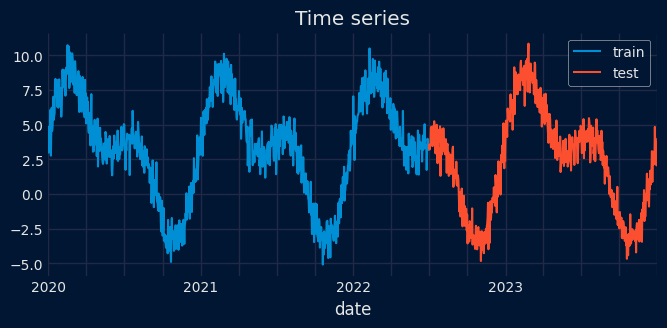

In [4]:
# Plot time series
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(title="Time series", label="train", ax=ax)
data_test['y'].plot(title="Time series", label="test", ax=ax)
ax.legend();

## One hot encoding

In [5]:
# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['month'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data_encoded_oh = one_hot_encoder.fit_transform(data)
data_encoded_oh.head(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,y
date,,,,,,,,,,,,,
2020-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.928244
2020-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.866145
2020-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.425159


## Cyclical encoding with sine/cosine transformation

In [6]:
# Cyclical encoding with sine/cosine transformation
# ==============================================================================
def sin_transformer(period):
	"""
	Returns a transformer that applies sine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	"""
	Returns a transformer that applies cosine transformation to a variable using
	the specified period.
	"""
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

data_encoded_sin_cos = data.copy()
data_encoded_sin_cos["month_sin"] = sin_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos["month_cos"] = cos_transformer(12).fit_transform(data_encoded_sin_cos['month'])
data_encoded_sin_cos.head()

,y,month,month_sin,month_cos
date,,,,
2020-01-01,2.928244,1,0.5,0.866025
2020-01-02,4.866145,1,0.5,0.866025
2020-01-03,4.425159,1,0.5,0.866025
2020-01-04,3.069222,1,0.5,0.866025
2020-01-05,4.021290,1,0.5,0.866025


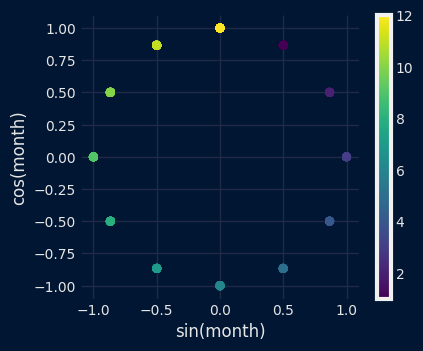

In [7]:
# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        data_encoded_sin_cos["month_sin"],
        data_encoded_sin_cos["month_cos"],
        c=data_encoded_sin_cos["month"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
_ = fig.colorbar(sp)
data_encoded_sin_cos = data_encoded_sin_cos.drop(columns='month')

## B-splines functions

In [8]:
# Create feature day of year
# ==============================================================================
data['day_of_year'] = data.index.day_of_year
data.head(3)

,y,month,day_of_year
date,,,
2020-01-01,2.928244,1,1
2020-01-02,4.866145,1,2
2020-01-03,4.425159,1,3


In [9]:
# B-spline functions
# ==============================================================================
def spline_transformer(period, degree=3, extrapolation="periodic"):
    """
    Returns a transformer that applies B-spline transformation.
    """
    return SplineTransformer(
               degree        = degree,
               n_knots       = period + 1,
               knots         = 'uniform',
               extrapolation = extrapolation,
               include_bias  = True
           ).set_output(transform="pandas")

splines_month = spline_transformer(period=12).fit_transform(data[['day_of_year']])
splines_month.columns = [f"spline{i}" for i in range(len(splines_month.columns))]

The graph below shows the 12 spline functions generated using the day of the year as input. Since 12 splines are created with knots evenly distributed along the range 1 to 365 (day_of_year), each curve represents the proximity to the beginning of a particular month.

In [10]:
# Location of the maximum value of each spline
# ==============================================================================
splines_month.idxmax()

spline0    2020-12-01
spline1    2020-01-01
spline2    2020-01-31
spline3    2020-03-02
spline4    2020-04-01
spline5    2020-05-02
spline6    2020-06-01
spline7    2020-07-02
spline8    2020-08-01
spline9    2020-08-31
spline10   2020-10-01
spline11   2020-10-31
dtype: datetime64[ns]

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_106012\1440543275.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  splines_month.head(365).plot(


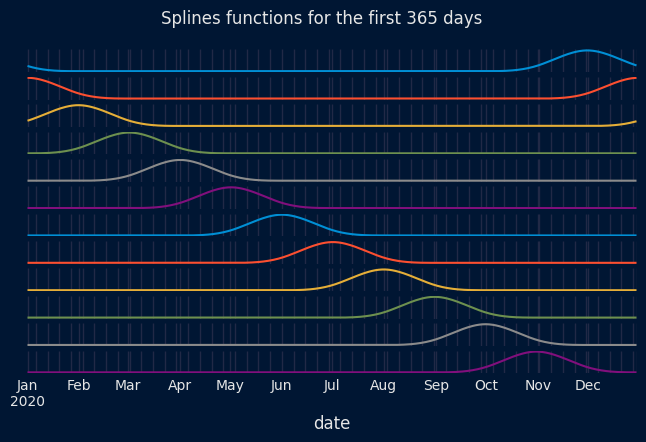

In [11]:
# Plot of the B-splines functions for the first 365 days
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
splines_month.head(365).plot(
    ax       = ax,
    subplots = True,
    sharex   = True,
    legend   = False,
    yticks   = [],
    title    = 'Splines functions for the first 365 days'
);

In [12]:
# Encoded data
# ==============================================================================
data_encoded_splines = pd.concat([data, splines_month], axis=1)
data_encoded_splines = data_encoded_splines.drop(columns=['day_of_year', 'month'])
data_encoded_splines.head(3)

,y,spline0,spline1,spline2,spline3,spline4,spline5,spline6,spline7,spline8,spline9,spline10,spline11
date,,,,,,,,,,,,,
2020-01-01,2.928244,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,4.866145,0.150763,0.665604,0.183628,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,4.425159,0.135904,0.662485,0.201563,0.000047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Radial basis functions (RBF)

The same encoding can be done using the `RepeatingBasisFunction` transformer from scikit-lego. The transformer is used to encode the day of the year into 12 radial basis functions.

In [13]:
# Radial basis functions
# ==============================================================================
rbf = RepeatingBasisFunction(
          n_periods   = 12,
          remainder   = 'drop',
          column      = 'day_of_year',
          input_range = (1, 366)
      )
rbf_month = rbf.fit_transform(data[['day_of_year']])
rbf_month = pd.DataFrame(
                data    = rbf_month,
                index   = data.index,
                columns = [f"rbf_{i}" for i in range(rbf_month.shape[1])]
            )
rbf_month.head(3)

,rbf_0,rbf_1,rbf_2,rbf_3,rbf_4,rbf_5,rbf_6,rbf_7,rbf_8,rbf_9,rbf_10,rbf_11
date,,,,,,,,,,,,
2020-01-01,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2020-01-02,0.998920,0.392457,0.020867,0.000150,1.462326e-07,1.927304e-11,3.437695e-16,9.985890e-12,8.641586e-08,0.000101,0.016041,0.344096
2020-01-03,0.995686,0.417773,0.023723,0.000182,1.896101e-07,2.668848e-11,5.083902e-16,7.164680e-12,6.621552e-08,0.000083,0.014019,0.321155


In [14]:
# Location of the maximum value of each rbf
# ==============================================================================
rbf_month.idxmax()

rbf_0    2020-01-01
rbf_1    2020-01-31
rbf_2    2020-03-02
rbf_3    2020-04-01
rbf_4    2020-05-02
rbf_5    2020-06-01
rbf_6    2020-07-01
rbf_7    2020-08-01
rbf_8    2020-08-31
rbf_9    2020-10-01
rbf_10   2020-10-31
rbf_11   2020-12-01
dtype: datetime64[ns]

In [15]:
# Encoded data
# ==============================================================================
data_encoded_rbf = pd.concat([data, rbf_month], axis=1)
data_encoded_rbf = data_encoded_rbf.drop(columns=['day_of_year', 'month'])
data_encoded_rbf.head(3)

,y,rbf_0,rbf_1,rbf_2,rbf_3,rbf_4,rbf_5,rbf_6,rbf_7,rbf_8,rbf_9,rbf_10,rbf_11
date,,,,,,,,,,,,,
2020-01-01,2.928244,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2020-01-02,4.866145,0.998920,0.392457,0.020867,0.000150,1.462326e-07,1.927304e-11,3.437695e-16,9.985890e-12,8.641586e-08,0.000101,0.016041,0.344096
2020-01-03,4.425159,0.995686,0.417773,0.023723,0.000182,1.896101e-07,2.668848e-11,5.083902e-16,7.164680e-12,6.621552e-08,0.000083,0.014019,0.321155


## Compare forecasting results

A non-informative lag is included so that the impact of cyclical features can be assessed without being obscured by the autoregressive component.

In [16]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = [70]
             )

  0%|          | 0/2 [00:00<?, ?it/s]

Backtest error using one hot encoding: 1.10


  0%|          | 0/2 [00:00<?, ?it/s]

Backtest error using sine/cosine encoding: 1.12


  0%|          | 0/2 [00:00<?, ?it/s]

Backtest error using spline encoding: 0.75


  0%|          | 0/2 [00:00<?, ?it/s]

Backtest error using rbf encoding: 0.74


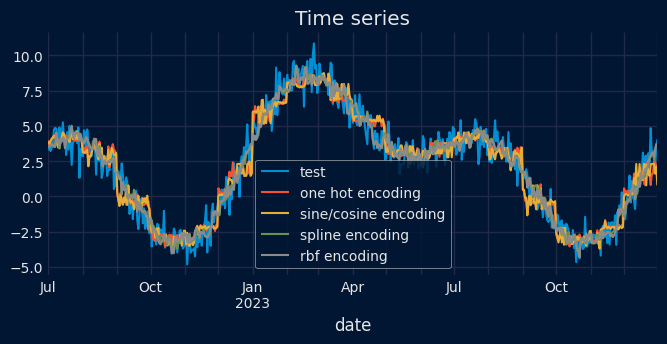

In [17]:
# Train and validate a forecaster using each encoding method
# ==============================================================================
datasets = [
    data_encoded_oh, data_encoded_sin_cos, data_encoded_splines, data_encoded_rbf
]
encoding_methods = [
    'one hot encoding', 'sine/cosine encoding', 'spline encoding', 'rbf encoding'
]

fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(title="Time series", label="test", ax=ax)

for i, data_encoded in enumerate(datasets):

    cv = TimeSeriesFold(
            steps              = 365,
            initial_train_size = len(data_encoded.loc[:end_train]),
            refit              = False,
         )
    metric, predictions = backtesting_forecaster(
                              forecaster    = forecaster,
                              y             = data_encoded['y'],
                              exog          = data_encoded.drop(columns='y'),
                              cv            = cv,
                              metric        = 'mean_squared_error'
                          )

    print(f"Backtest error using {encoding_methods[i]}: {metric.at[0, 'mean_squared_error']:.2f}")
    predictions.plot(label=encoding_methods[i], ax=ax)
    ax.legend(labels=['test'] + encoding_methods)
    
plt.show();